# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

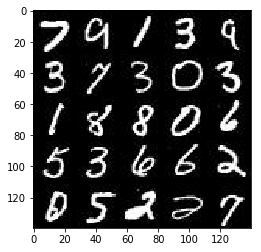

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

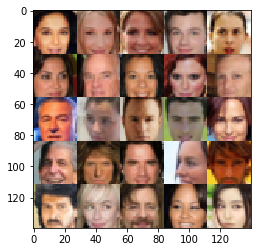

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name="inputs")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32,name="learning_rate")
    return inputs, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)

        # Flatten it
        flat = tf.reshape(relu4, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out
    



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels_dim = data_shape
    input_real, input_z, _ = model_inputs(image_width, image_height, image_channels_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    print_every=10
    show_every=100
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                # TODO: Train Model
                
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels_dim, data_image_mode)
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 7.4522... Generator Loss: 0.0019
Epoch 0/2... Discriminator Loss: 0.7997... Generator Loss: 1.6507
Epoch 0/2... Discriminator Loss: 7.2973... Generator Loss: 0.0025
Epoch 0/2... Discriminator Loss: 1.3391... Generator Loss: 3.9945
Epoch 0/2... Discriminator Loss: 1.4284... Generator Loss: 1.0065
Epoch 0/2... Discriminator Loss: 1.8848... Generator Loss: 0.4706
Epoch 0/2... Discriminator Loss: 1.5012... Generator Loss: 2.2139
Epoch 0/2... Discriminator Loss: 2.0194... Generator Loss: 0.3829
Epoch 0/2... Discriminator Loss: 1.7686... Generator Loss: 3.6550


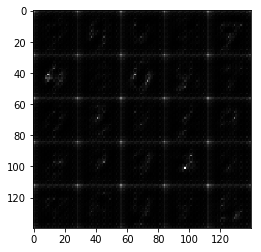

Epoch 0/2... Discriminator Loss: 1.1011... Generator Loss: 1.9145
Epoch 0/2... Discriminator Loss: 0.8764... Generator Loss: 1.7552
Epoch 0/2... Discriminator Loss: 1.3457... Generator Loss: 2.9083
Epoch 0/2... Discriminator Loss: 1.0370... Generator Loss: 2.7555
Epoch 0/2... Discriminator Loss: 0.8195... Generator Loss: 2.9314
Epoch 0/2... Discriminator Loss: 0.6772... Generator Loss: 1.7896
Epoch 0/2... Discriminator Loss: 1.1559... Generator Loss: 2.9440
Epoch 0/2... Discriminator Loss: 0.6741... Generator Loss: 1.5678
Epoch 0/2... Discriminator Loss: 1.5154... Generator Loss: 0.3346
Epoch 0/2... Discriminator Loss: 1.0042... Generator Loss: 2.2435


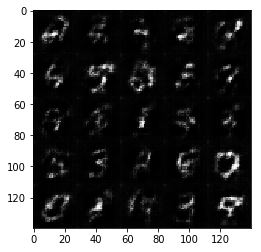

Epoch 0/2... Discriminator Loss: 1.1054... Generator Loss: 0.6705
Epoch 0/2... Discriminator Loss: 0.6111... Generator Loss: 1.4797
Epoch 0/2... Discriminator Loss: 0.6031... Generator Loss: 1.7689
Epoch 0/2... Discriminator Loss: 1.6108... Generator Loss: 3.5345
Epoch 0/2... Discriminator Loss: 0.7711... Generator Loss: 0.9015
Epoch 0/2... Discriminator Loss: 0.8229... Generator Loss: 2.0364
Epoch 0/2... Discriminator Loss: 1.7584... Generator Loss: 0.3602
Epoch 0/2... Discriminator Loss: 0.5397... Generator Loss: 1.7441
Epoch 0/2... Discriminator Loss: 1.9073... Generator Loss: 4.1538
Epoch 0/2... Discriminator Loss: 0.5986... Generator Loss: 1.5834


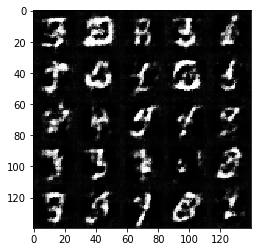

Epoch 0/2... Discriminator Loss: 0.7304... Generator Loss: 1.9582
Epoch 0/2... Discriminator Loss: 0.9846... Generator Loss: 3.4376
Epoch 0/2... Discriminator Loss: 0.7404... Generator Loss: 2.5966
Epoch 0/2... Discriminator Loss: 0.5867... Generator Loss: 1.3709
Epoch 0/2... Discriminator Loss: 0.9021... Generator Loss: 0.7998
Epoch 0/2... Discriminator Loss: 1.0344... Generator Loss: 0.6812
Epoch 0/2... Discriminator Loss: 0.5708... Generator Loss: 1.7728
Epoch 0/2... Discriminator Loss: 0.5503... Generator Loss: 1.7469
Epoch 0/2... Discriminator Loss: 1.4706... Generator Loss: 0.3666
Epoch 0/2... Discriminator Loss: 0.7149... Generator Loss: 1.6442


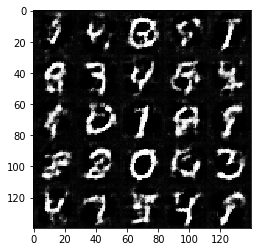

Epoch 0/2... Discriminator Loss: 1.4847... Generator Loss: 0.4728
Epoch 0/2... Discriminator Loss: 0.4464... Generator Loss: 1.7335
Epoch 0/2... Discriminator Loss: 1.0097... Generator Loss: 0.6460
Epoch 0/2... Discriminator Loss: 0.6902... Generator Loss: 2.6930
Epoch 0/2... Discriminator Loss: 0.8103... Generator Loss: 0.8962
Epoch 0/2... Discriminator Loss: 0.6902... Generator Loss: 2.7026
Epoch 0/2... Discriminator Loss: 0.6975... Generator Loss: 1.4451
Epoch 0/2... Discriminator Loss: 0.9229... Generator Loss: 0.8180
Epoch 0/2... Discriminator Loss: 0.5350... Generator Loss: 1.6663
Epoch 0/2... Discriminator Loss: 1.8297... Generator Loss: 4.1879


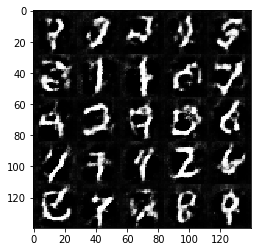

Epoch 0/2... Discriminator Loss: 1.9504... Generator Loss: 4.2566
Epoch 0/2... Discriminator Loss: 0.9147... Generator Loss: 0.7140
Epoch 0/2... Discriminator Loss: 0.6154... Generator Loss: 1.3999
Epoch 0/2... Discriminator Loss: 1.0438... Generator Loss: 0.6291
Epoch 0/2... Discriminator Loss: 0.9014... Generator Loss: 0.9563
Epoch 0/2... Discriminator Loss: 0.7996... Generator Loss: 0.8996
Epoch 0/2... Discriminator Loss: 1.7676... Generator Loss: 0.3619
Epoch 0/2... Discriminator Loss: 1.2133... Generator Loss: 0.5637
Epoch 0/2... Discriminator Loss: 0.5405... Generator Loss: 1.4789
Epoch 0/2... Discriminator Loss: 1.7317... Generator Loss: 0.3012


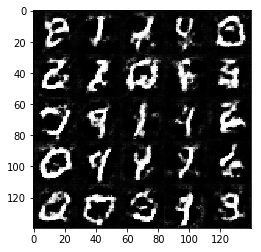

Epoch 0/2... Discriminator Loss: 4.7410... Generator Loss: 0.0325
Epoch 0/2... Discriminator Loss: 2.6391... Generator Loss: 5.2866
Epoch 0/2... Discriminator Loss: 0.8709... Generator Loss: 0.8966
Epoch 0/2... Discriminator Loss: 0.6507... Generator Loss: 1.0716
Epoch 0/2... Discriminator Loss: 1.4550... Generator Loss: 0.4215
Epoch 0/2... Discriminator Loss: 1.2451... Generator Loss: 0.5543
Epoch 0/2... Discriminator Loss: 0.5825... Generator Loss: 1.3610
Epoch 0/2... Discriminator Loss: 0.6641... Generator Loss: 1.1248
Epoch 0/2... Discriminator Loss: 0.4370... Generator Loss: 1.4764
Epoch 0/2... Discriminator Loss: 1.6596... Generator Loss: 3.1147


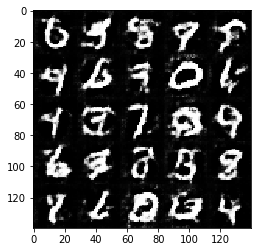

Epoch 0/2... Discriminator Loss: 1.3537... Generator Loss: 2.9890
Epoch 0/2... Discriminator Loss: 0.5450... Generator Loss: 1.2892
Epoch 0/2... Discriminator Loss: 0.5882... Generator Loss: 1.3308
Epoch 0/2... Discriminator Loss: 1.1783... Generator Loss: 0.5780
Epoch 0/2... Discriminator Loss: 0.6458... Generator Loss: 1.2400
Epoch 0/2... Discriminator Loss: 0.6303... Generator Loss: 1.1141
Epoch 0/2... Discriminator Loss: 0.8230... Generator Loss: 0.9477
Epoch 0/2... Discriminator Loss: 0.9262... Generator Loss: 0.7679
Epoch 0/2... Discriminator Loss: 1.1110... Generator Loss: 0.6363
Epoch 0/2... Discriminator Loss: 1.5238... Generator Loss: 0.3864


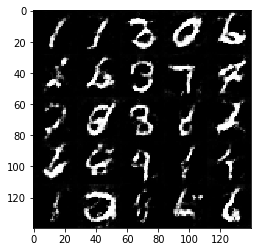

Epoch 0/2... Discriminator Loss: 0.9493... Generator Loss: 0.9136
Epoch 0/2... Discriminator Loss: 0.5201... Generator Loss: 1.2276
Epoch 0/2... Discriminator Loss: 0.7969... Generator Loss: 0.9280
Epoch 0/2... Discriminator Loss: 0.8727... Generator Loss: 0.7956
Epoch 0/2... Discriminator Loss: 0.4757... Generator Loss: 1.5830
Epoch 0/2... Discriminator Loss: 0.9488... Generator Loss: 0.7260
Epoch 0/2... Discriminator Loss: 0.8469... Generator Loss: 3.3713
Epoch 0/2... Discriminator Loss: 0.6273... Generator Loss: 1.5630
Epoch 0/2... Discriminator Loss: 0.5940... Generator Loss: 1.2153
Epoch 0/2... Discriminator Loss: 1.2822... Generator Loss: 0.6893


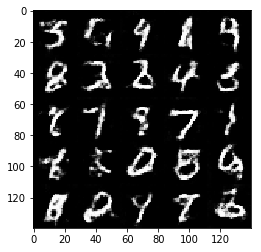

Epoch 0/2... Discriminator Loss: 1.9895... Generator Loss: 0.3313
Epoch 0/2... Discriminator Loss: 1.0262... Generator Loss: 3.2642
Epoch 0/2... Discriminator Loss: 0.8400... Generator Loss: 3.0186
Epoch 0/2... Discriminator Loss: 1.4588... Generator Loss: 0.4266
Epoch 1/2... Discriminator Loss: 1.3667... Generator Loss: 0.4433
Epoch 1/2... Discriminator Loss: 1.3587... Generator Loss: 0.4823
Epoch 1/2... Discriminator Loss: 0.6108... Generator Loss: 1.1491
Epoch 1/2... Discriminator Loss: 0.3990... Generator Loss: 2.7305
Epoch 1/2... Discriminator Loss: 0.6040... Generator Loss: 1.5417
Epoch 1/2... Discriminator Loss: 1.6935... Generator Loss: 0.4083


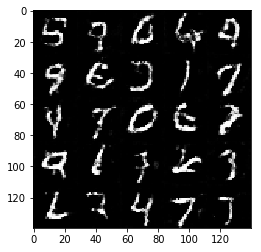

Epoch 1/2... Discriminator Loss: 1.7750... Generator Loss: 0.3564
Epoch 1/2... Discriminator Loss: 0.5635... Generator Loss: 1.2149
Epoch 1/2... Discriminator Loss: 0.6296... Generator Loss: 1.4743
Epoch 1/2... Discriminator Loss: 1.8103... Generator Loss: 0.4484
Epoch 1/2... Discriminator Loss: 0.8398... Generator Loss: 0.8840
Epoch 1/2... Discriminator Loss: 1.9180... Generator Loss: 0.3543
Epoch 1/2... Discriminator Loss: 0.7518... Generator Loss: 1.0450
Epoch 1/2... Discriminator Loss: 0.7389... Generator Loss: 1.3092
Epoch 1/2... Discriminator Loss: 0.6074... Generator Loss: 1.1370
Epoch 1/2... Discriminator Loss: 0.6929... Generator Loss: 1.1067


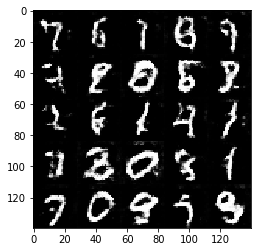

Epoch 1/2... Discriminator Loss: 0.7372... Generator Loss: 0.8950
Epoch 1/2... Discriminator Loss: 0.6108... Generator Loss: 1.2809
Epoch 1/2... Discriminator Loss: 0.8220... Generator Loss: 0.8088
Epoch 1/2... Discriminator Loss: 1.2421... Generator Loss: 2.5709
Epoch 1/2... Discriminator Loss: 0.6217... Generator Loss: 1.2639
Epoch 1/2... Discriminator Loss: 2.0057... Generator Loss: 0.2697
Epoch 1/2... Discriminator Loss: 0.9295... Generator Loss: 0.7971
Epoch 1/2... Discriminator Loss: 0.6702... Generator Loss: 1.0853
Epoch 1/2... Discriminator Loss: 1.0732... Generator Loss: 0.6007
Epoch 1/2... Discriminator Loss: 0.8731... Generator Loss: 0.8680


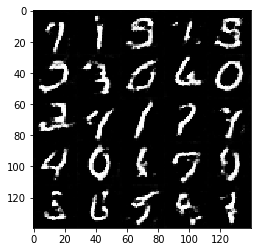

Epoch 1/2... Discriminator Loss: 1.6517... Generator Loss: 0.4846
Epoch 1/2... Discriminator Loss: 0.6118... Generator Loss: 1.1577
Epoch 1/2... Discriminator Loss: 1.0531... Generator Loss: 0.6403
Epoch 1/2... Discriminator Loss: 0.7100... Generator Loss: 0.9745
Epoch 1/2... Discriminator Loss: 1.0944... Generator Loss: 0.6275
Epoch 1/2... Discriminator Loss: 0.7535... Generator Loss: 0.9288
Epoch 1/2... Discriminator Loss: 1.0528... Generator Loss: 0.6322
Epoch 1/2... Discriminator Loss: 0.4241... Generator Loss: 2.3055
Epoch 1/2... Discriminator Loss: 1.5063... Generator Loss: 0.4822
Epoch 1/2... Discriminator Loss: 1.2132... Generator Loss: 0.6104


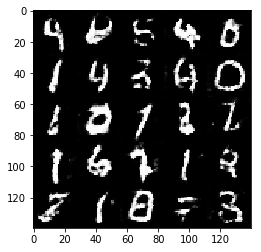

Epoch 1/2... Discriminator Loss: 0.8016... Generator Loss: 0.8530
Epoch 1/2... Discriminator Loss: 0.4021... Generator Loss: 1.6853
Epoch 1/2... Discriminator Loss: 0.5974... Generator Loss: 1.8783
Epoch 1/2... Discriminator Loss: 2.4833... Generator Loss: 0.2507
Epoch 1/2... Discriminator Loss: 0.9042... Generator Loss: 0.9310
Epoch 1/2... Discriminator Loss: 0.7107... Generator Loss: 1.1423
Epoch 1/2... Discriminator Loss: 1.2587... Generator Loss: 0.5484
Epoch 1/2... Discriminator Loss: 1.2895... Generator Loss: 0.6031
Epoch 1/2... Discriminator Loss: 0.8168... Generator Loss: 0.8931
Epoch 1/2... Discriminator Loss: 1.0858... Generator Loss: 0.6680


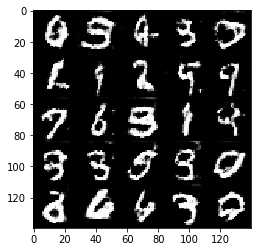

Epoch 1/2... Discriminator Loss: 0.7214... Generator Loss: 1.0117
Epoch 1/2... Discriminator Loss: 0.3786... Generator Loss: 1.6688
Epoch 1/2... Discriminator Loss: 0.9940... Generator Loss: 0.7320
Epoch 1/2... Discriminator Loss: 1.4458... Generator Loss: 0.4959
Epoch 1/2... Discriminator Loss: 0.7062... Generator Loss: 0.9773
Epoch 1/2... Discriminator Loss: 0.5804... Generator Loss: 1.0857
Epoch 1/2... Discriminator Loss: 0.2753... Generator Loss: 1.8281
Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 0.6387
Epoch 1/2... Discriminator Loss: 1.0253... Generator Loss: 0.7056
Epoch 1/2... Discriminator Loss: 0.8798... Generator Loss: 0.7944


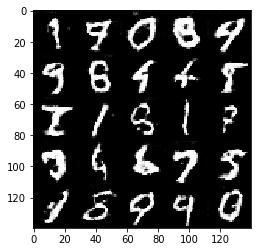

Epoch 1/2... Discriminator Loss: 0.7228... Generator Loss: 0.9379
Epoch 1/2... Discriminator Loss: 1.8177... Generator Loss: 0.2891
Epoch 1/2... Discriminator Loss: 0.5915... Generator Loss: 1.2381
Epoch 1/2... Discriminator Loss: 0.4446... Generator Loss: 1.6297
Epoch 1/2... Discriminator Loss: 0.7327... Generator Loss: 1.5249
Epoch 1/2... Discriminator Loss: 2.2597... Generator Loss: 8.1790
Epoch 1/2... Discriminator Loss: 0.5158... Generator Loss: 2.2730
Epoch 1/2... Discriminator Loss: 0.8919... Generator Loss: 0.8300
Epoch 1/2... Discriminator Loss: 0.4911... Generator Loss: 1.5307
Epoch 1/2... Discriminator Loss: 1.0033... Generator Loss: 0.8418


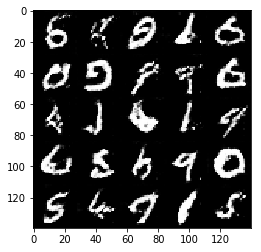

Epoch 1/2... Discriminator Loss: 1.3565... Generator Loss: 0.5983
Epoch 1/2... Discriminator Loss: 0.4836... Generator Loss: 1.7395
Epoch 1/2... Discriminator Loss: 0.5649... Generator Loss: 1.8786
Epoch 1/2... Discriminator Loss: 0.3208... Generator Loss: 2.5539
Epoch 1/2... Discriminator Loss: 0.5724... Generator Loss: 3.3243
Epoch 1/2... Discriminator Loss: 0.8261... Generator Loss: 1.4283
Epoch 1/2... Discriminator Loss: 0.6369... Generator Loss: 1.1958
Epoch 1/2... Discriminator Loss: 0.7746... Generator Loss: 0.9825
Epoch 1/2... Discriminator Loss: 0.6455... Generator Loss: 1.0831
Epoch 1/2... Discriminator Loss: 0.8633... Generator Loss: 0.8194


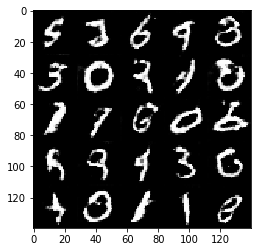

Epoch 1/2... Discriminator Loss: 0.7233... Generator Loss: 0.9180
Epoch 1/2... Discriminator Loss: 1.0878... Generator Loss: 0.6378
Epoch 1/2... Discriminator Loss: 0.7034... Generator Loss: 1.0218
Epoch 1/2... Discriminator Loss: 0.5241... Generator Loss: 1.2842
Epoch 1/2... Discriminator Loss: 6.9683... Generator Loss: 11.2065
Epoch 1/2... Discriminator Loss: 1.1604... Generator Loss: 3.6215
Epoch 1/2... Discriminator Loss: 0.5907... Generator Loss: 2.8197
Epoch 1/2... Discriminator Loss: 0.4465... Generator Loss: 3.0797
Epoch 1/2... Discriminator Loss: 0.3876... Generator Loss: 2.8525
Epoch 1/2... Discriminator Loss: 0.6895... Generator Loss: 1.1870


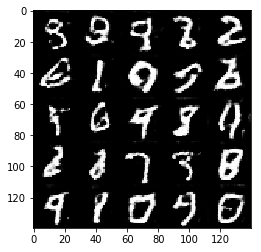

Epoch 1/2... Discriminator Loss: 0.6286... Generator Loss: 1.2058
Epoch 1/2... Discriminator Loss: 0.9487... Generator Loss: 0.7139
Epoch 1/2... Discriminator Loss: 1.8752... Generator Loss: 0.3536
Epoch 1/2... Discriminator Loss: 6.9404... Generator Loss: 0.0107
Epoch 1/2... Discriminator Loss: 0.6366... Generator Loss: 2.0731
Epoch 1/2... Discriminator Loss: 0.6564... Generator Loss: 1.5926
Epoch 1/2... Discriminator Loss: 0.6103... Generator Loss: 1.3240
Epoch 1/2... Discriminator Loss: 1.1641... Generator Loss: 3.8594


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 1.4040... Generator Loss: 3.1783
Epoch 0/1... Discriminator Loss: 0.5063... Generator Loss: 15.7394
Epoch 0/1... Discriminator Loss: 2.8527... Generator Loss: 0.2204
Epoch 0/1... Discriminator Loss: 2.3734... Generator Loss: 15.6178
Epoch 0/1... Discriminator Loss: 1.1416... Generator Loss: 2.3440
Epoch 0/1... Discriminator Loss: 0.4378... Generator Loss: 3.4083
Epoch 0/1... Discriminator Loss: 2.9336... Generator Loss: 0.1496
Epoch 0/1... Discriminator Loss: 1.2927... Generator Loss: 4.8972
Epoch 0/1... Discriminator Loss: 0.6155... Generator Loss: 1.6271


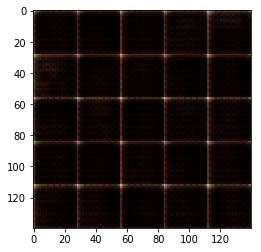

Epoch 0/1... Discriminator Loss: 1.2373... Generator Loss: 0.6588
Epoch 0/1... Discriminator Loss: 0.8022... Generator Loss: 1.4188
Epoch 0/1... Discriminator Loss: 0.8463... Generator Loss: 3.9791
Epoch 0/1... Discriminator Loss: 1.3127... Generator Loss: 0.6481
Epoch 0/1... Discriminator Loss: 1.0081... Generator Loss: 1.3326
Epoch 0/1... Discriminator Loss: 0.5759... Generator Loss: 1.4993
Epoch 0/1... Discriminator Loss: 0.8726... Generator Loss: 1.9336
Epoch 0/1... Discriminator Loss: 1.8020... Generator Loss: 0.3308
Epoch 0/1... Discriminator Loss: 1.2009... Generator Loss: 0.5962
Epoch 0/1... Discriminator Loss: 1.1186... Generator Loss: 0.6536


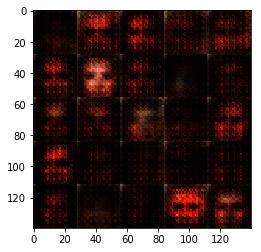

Epoch 0/1... Discriminator Loss: 1.5120... Generator Loss: 0.4300
Epoch 0/1... Discriminator Loss: 0.8180... Generator Loss: 0.9022
Epoch 0/1... Discriminator Loss: 1.2554... Generator Loss: 0.8479
Epoch 0/1... Discriminator Loss: 0.9799... Generator Loss: 1.9812
Epoch 0/1... Discriminator Loss: 0.8209... Generator Loss: 1.8789
Epoch 0/1... Discriminator Loss: 0.8329... Generator Loss: 1.3242
Epoch 0/1... Discriminator Loss: 1.4431... Generator Loss: 0.5509
Epoch 0/1... Discriminator Loss: 1.1397... Generator Loss: 2.0972
Epoch 0/1... Discriminator Loss: 0.9163... Generator Loss: 1.0250
Epoch 0/1... Discriminator Loss: 1.2880... Generator Loss: 0.6825


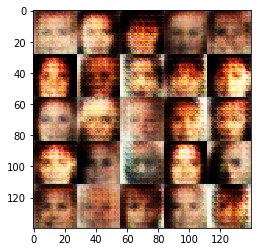

Epoch 0/1... Discriminator Loss: 1.0564... Generator Loss: 0.8728
Epoch 0/1... Discriminator Loss: 0.9119... Generator Loss: 0.8304
Epoch 0/1... Discriminator Loss: 1.6195... Generator Loss: 0.3659
Epoch 0/1... Discriminator Loss: 1.2050... Generator Loss: 1.2325
Epoch 0/1... Discriminator Loss: 1.4232... Generator Loss: 2.0503
Epoch 0/1... Discriminator Loss: 1.5220... Generator Loss: 0.7409
Epoch 0/1... Discriminator Loss: 1.3885... Generator Loss: 0.5194
Epoch 0/1... Discriminator Loss: 2.1862... Generator Loss: 0.2378
Epoch 0/1... Discriminator Loss: 1.0320... Generator Loss: 1.1500
Epoch 0/1... Discriminator Loss: 1.0994... Generator Loss: 0.9704


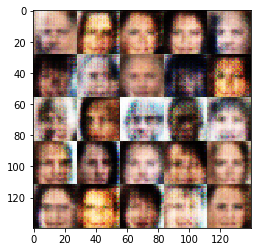

Epoch 0/1... Discriminator Loss: 1.0307... Generator Loss: 1.0207
Epoch 0/1... Discriminator Loss: 1.2934... Generator Loss: 0.5594
Epoch 0/1... Discriminator Loss: 1.6681... Generator Loss: 1.8078
Epoch 0/1... Discriminator Loss: 1.1378... Generator Loss: 0.6704
Epoch 0/1... Discriminator Loss: 1.4541... Generator Loss: 1.3930
Epoch 0/1... Discriminator Loss: 1.3760... Generator Loss: 0.4554
Epoch 0/1... Discriminator Loss: 1.4191... Generator Loss: 0.6814
Epoch 0/1... Discriminator Loss: 1.4135... Generator Loss: 0.6516
Epoch 0/1... Discriminator Loss: 1.4167... Generator Loss: 0.4474
Epoch 0/1... Discriminator Loss: 1.2094... Generator Loss: 0.7940


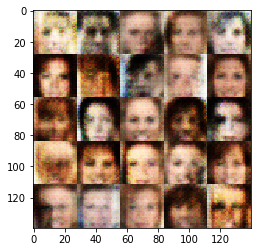

Epoch 0/1... Discriminator Loss: 1.4686... Generator Loss: 2.0585
Epoch 0/1... Discriminator Loss: 1.1150... Generator Loss: 0.8507
Epoch 0/1... Discriminator Loss: 1.0690... Generator Loss: 1.0353
Epoch 0/1... Discriminator Loss: 1.2609... Generator Loss: 0.7159
Epoch 0/1... Discriminator Loss: 1.6245... Generator Loss: 0.5442
Epoch 0/1... Discriminator Loss: 1.2637... Generator Loss: 0.8842
Epoch 0/1... Discriminator Loss: 1.6307... Generator Loss: 0.3970
Epoch 0/1... Discriminator Loss: 1.1464... Generator Loss: 0.6944
Epoch 0/1... Discriminator Loss: 1.1535... Generator Loss: 0.8492
Epoch 0/1... Discriminator Loss: 1.3464... Generator Loss: 1.1482


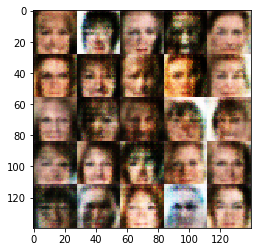

Epoch 0/1... Discriminator Loss: 1.2467... Generator Loss: 1.1346
Epoch 0/1... Discriminator Loss: 1.1303... Generator Loss: 0.6477
Epoch 0/1... Discriminator Loss: 1.2959... Generator Loss: 0.5825
Epoch 0/1... Discriminator Loss: 0.9994... Generator Loss: 1.2062
Epoch 0/1... Discriminator Loss: 1.6701... Generator Loss: 0.3323
Epoch 0/1... Discriminator Loss: 1.3039... Generator Loss: 0.6120
Epoch 0/1... Discriminator Loss: 1.2087... Generator Loss: 0.8510
Epoch 0/1... Discriminator Loss: 1.1693... Generator Loss: 1.0135
Epoch 0/1... Discriminator Loss: 1.2129... Generator Loss: 0.9076
Epoch 0/1... Discriminator Loss: 1.2234... Generator Loss: 0.7772


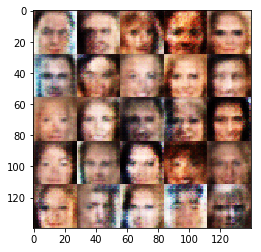

Epoch 0/1... Discriminator Loss: 1.1827... Generator Loss: 0.5341
Epoch 0/1... Discriminator Loss: 1.1144... Generator Loss: 1.3116
Epoch 0/1... Discriminator Loss: 1.3487... Generator Loss: 0.8343
Epoch 0/1... Discriminator Loss: 1.2182... Generator Loss: 0.7189
Epoch 0/1... Discriminator Loss: 1.2136... Generator Loss: 0.5138
Epoch 0/1... Discriminator Loss: 1.1501... Generator Loss: 1.1482
Epoch 0/1... Discriminator Loss: 1.0879... Generator Loss: 1.1463
Epoch 0/1... Discriminator Loss: 1.4632... Generator Loss: 0.3574
Epoch 0/1... Discriminator Loss: 1.6305... Generator Loss: 2.4294
Epoch 0/1... Discriminator Loss: 1.2741... Generator Loss: 1.4440


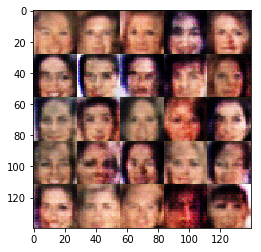

Epoch 0/1... Discriminator Loss: 1.6541... Generator Loss: 0.3479
Epoch 0/1... Discriminator Loss: 1.6209... Generator Loss: 0.3157
Epoch 0/1... Discriminator Loss: 1.0920... Generator Loss: 0.5694
Epoch 0/1... Discriminator Loss: 1.4783... Generator Loss: 0.4060
Epoch 0/1... Discriminator Loss: 1.1651... Generator Loss: 0.7100
Epoch 0/1... Discriminator Loss: 1.4386... Generator Loss: 1.5245
Epoch 0/1... Discriminator Loss: 3.3407... Generator Loss: 0.0528
Epoch 0/1... Discriminator Loss: 1.2581... Generator Loss: 0.6508
Epoch 0/1... Discriminator Loss: 1.2175... Generator Loss: 2.1415
Epoch 0/1... Discriminator Loss: 0.5856... Generator Loss: 2.0415


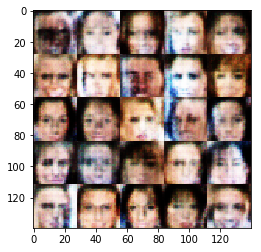

Epoch 0/1... Discriminator Loss: 0.9302... Generator Loss: 0.8636
Epoch 0/1... Discriminator Loss: 0.3820... Generator Loss: 3.0546
Epoch 0/1... Discriminator Loss: 0.8643... Generator Loss: 0.8261
Epoch 0/1... Discriminator Loss: 0.3393... Generator Loss: 1.8144
Epoch 0/1... Discriminator Loss: 0.1008... Generator Loss: 3.5945
Epoch 0/1... Discriminator Loss: 1.3625... Generator Loss: 0.3990
Epoch 0/1... Discriminator Loss: 0.2108... Generator Loss: 2.3884
Epoch 0/1... Discriminator Loss: 0.4778... Generator Loss: 1.4151
Epoch 0/1... Discriminator Loss: 0.4682... Generator Loss: 1.3647
Epoch 0/1... Discriminator Loss: 0.7982... Generator Loss: 0.9350


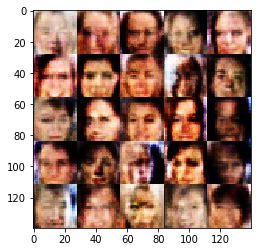

Epoch 0/1... Discriminator Loss: 0.2957... Generator Loss: 1.7776
Epoch 0/1... Discriminator Loss: 0.2066... Generator Loss: 4.1013
Epoch 0/1... Discriminator Loss: 0.6856... Generator Loss: 0.8935
Epoch 0/1... Discriminator Loss: 0.5748... Generator Loss: 1.5685
Epoch 0/1... Discriminator Loss: 0.8812... Generator Loss: 0.8381
Epoch 0/1... Discriminator Loss: 0.1864... Generator Loss: 2.9047
Epoch 0/1... Discriminator Loss: 0.5906... Generator Loss: 7.6228
Epoch 0/1... Discriminator Loss: 0.1229... Generator Loss: 3.0191
Epoch 0/1... Discriminator Loss: 0.5256... Generator Loss: 6.6195
Epoch 0/1... Discriminator Loss: 0.1889... Generator Loss: 2.3020


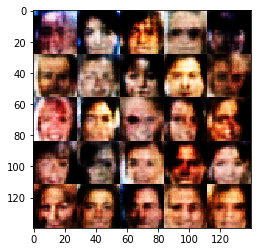

Epoch 0/1... Discriminator Loss: 0.0476... Generator Loss: 4.2611
Epoch 0/1... Discriminator Loss: 0.5278... Generator Loss: 1.3022
Epoch 0/1... Discriminator Loss: 0.2088... Generator Loss: 2.9953
Epoch 0/1... Discriminator Loss: 2.3483... Generator Loss: 4.5204
Epoch 0/1... Discriminator Loss: 0.0713... Generator Loss: 4.4622
Epoch 0/1... Discriminator Loss: 0.6794... Generator Loss: 1.0219
Epoch 0/1... Discriminator Loss: 0.5917... Generator Loss: 1.1098
Epoch 0/1... Discriminator Loss: 0.5034... Generator Loss: 1.1846
Epoch 0/1... Discriminator Loss: 0.0321... Generator Loss: 4.9652
Epoch 0/1... Discriminator Loss: 0.9929... Generator Loss: 1.2639


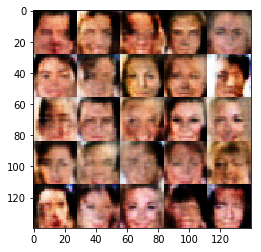

Epoch 0/1... Discriminator Loss: 0.2147... Generator Loss: 2.2883
Epoch 0/1... Discriminator Loss: 0.2246... Generator Loss: 5.0153
Epoch 0/1... Discriminator Loss: 0.0558... Generator Loss: 4.5988
Epoch 0/1... Discriminator Loss: 3.1848... Generator Loss: 0.0851
Epoch 0/1... Discriminator Loss: 0.1803... Generator Loss: 3.5195
Epoch 0/1... Discriminator Loss: 0.1015... Generator Loss: 5.3950
Epoch 0/1... Discriminator Loss: 0.1792... Generator Loss: 3.1186
Epoch 0/1... Discriminator Loss: 0.0526... Generator Loss: 3.9725
Epoch 0/1... Discriminator Loss: 0.3967... Generator Loss: 1.5841
Epoch 0/1... Discriminator Loss: 0.0882... Generator Loss: 3.1689


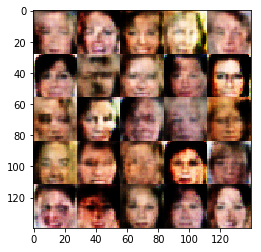

Epoch 0/1... Discriminator Loss: 0.0506... Generator Loss: 10.4469
Epoch 0/1... Discriminator Loss: 4.2963... Generator Loss: 0.0564
Epoch 0/1... Discriminator Loss: 0.4881... Generator Loss: 1.3466
Epoch 0/1... Discriminator Loss: 1.0032... Generator Loss: 0.6673
Epoch 0/1... Discriminator Loss: 0.6314... Generator Loss: 1.1426
Epoch 0/1... Discriminator Loss: 0.4785... Generator Loss: 6.7774
Epoch 0/1... Discriminator Loss: 0.7756... Generator Loss: 0.9834
Epoch 0/1... Discriminator Loss: 1.1130... Generator Loss: 0.6140
Epoch 0/1... Discriminator Loss: 0.3919... Generator Loss: 1.7281
Epoch 0/1... Discriminator Loss: 0.9682... Generator Loss: 0.6998


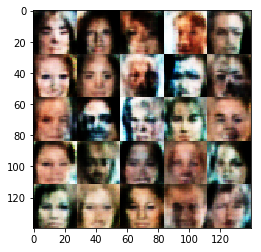

Epoch 0/1... Discriminator Loss: 0.0722... Generator Loss: 3.1765
Epoch 0/1... Discriminator Loss: 0.0536... Generator Loss: 6.5805
Epoch 0/1... Discriminator Loss: 0.4461... Generator Loss: 1.3327
Epoch 0/1... Discriminator Loss: 0.4232... Generator Loss: 1.4101
Epoch 0/1... Discriminator Loss: 0.1607... Generator Loss: 2.8965
Epoch 0/1... Discriminator Loss: 0.6860... Generator Loss: 5.1826
Epoch 0/1... Discriminator Loss: 0.2273... Generator Loss: 6.3664
Epoch 0/1... Discriminator Loss: 0.0634... Generator Loss: 3.3768
Epoch 0/1... Discriminator Loss: 5.1787... Generator Loss: 0.0110
Epoch 0/1... Discriminator Loss: 1.3174... Generator Loss: 0.7777


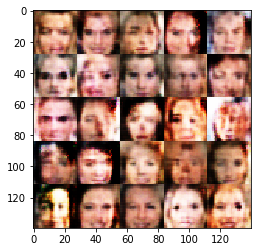

Epoch 0/1... Discriminator Loss: 1.0425... Generator Loss: 1.9071
Epoch 0/1... Discriminator Loss: 0.8410... Generator Loss: 1.5676
Epoch 0/1... Discriminator Loss: 0.7786... Generator Loss: 1.4371
Epoch 0/1... Discriminator Loss: 1.0426... Generator Loss: 0.7576
Epoch 0/1... Discriminator Loss: 0.8585... Generator Loss: 2.2803
Epoch 0/1... Discriminator Loss: 0.7440... Generator Loss: 1.3704
Epoch 0/1... Discriminator Loss: 0.8207... Generator Loss: 1.6328
Epoch 0/1... Discriminator Loss: 0.6937... Generator Loss: 1.5249
Epoch 0/1... Discriminator Loss: 0.6565... Generator Loss: 1.7796
Epoch 0/1... Discriminator Loss: 1.1772... Generator Loss: 0.5144


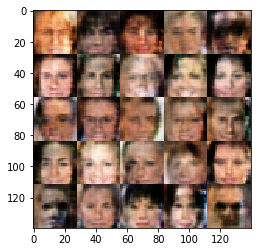

Epoch 0/1... Discriminator Loss: 0.5992... Generator Loss: 2.0056
Epoch 0/1... Discriminator Loss: 1.5215... Generator Loss: 0.5200
Epoch 0/1... Discriminator Loss: 0.5253... Generator Loss: 1.5825
Epoch 0/1... Discriminator Loss: 1.5114... Generator Loss: 0.4094
Epoch 0/1... Discriminator Loss: 1.1434... Generator Loss: 0.5662
Epoch 0/1... Discriminator Loss: 0.7062... Generator Loss: 1.9492
Epoch 0/1... Discriminator Loss: 0.9171... Generator Loss: 0.8914
Epoch 0/1... Discriminator Loss: 0.8544... Generator Loss: 1.1850
Epoch 0/1... Discriminator Loss: 0.7253... Generator Loss: 2.4044
Epoch 0/1... Discriminator Loss: 0.6894... Generator Loss: 1.1722


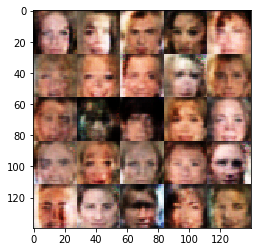

Epoch 0/1... Discriminator Loss: 0.7782... Generator Loss: 1.8336
Epoch 0/1... Discriminator Loss: 1.5461... Generator Loss: 0.3263
Epoch 0/1... Discriminator Loss: 1.5361... Generator Loss: 0.3809
Epoch 0/1... Discriminator Loss: 1.2197... Generator Loss: 0.7357
Epoch 0/1... Discriminator Loss: 0.7190... Generator Loss: 1.3718
Epoch 0/1... Discriminator Loss: 1.8404... Generator Loss: 0.3629
Epoch 0/1... Discriminator Loss: 0.7134... Generator Loss: 1.2738
Epoch 0/1... Discriminator Loss: 0.6333... Generator Loss: 4.8624
Epoch 0/1... Discriminator Loss: 0.8644... Generator Loss: 0.6548
Epoch 0/1... Discriminator Loss: 0.4329... Generator Loss: 1.3653


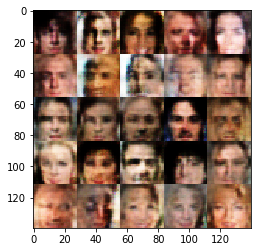

Epoch 0/1... Discriminator Loss: 1.6090... Generator Loss: 0.3965
Epoch 0/1... Discriminator Loss: 0.4007... Generator Loss: 1.8672
Epoch 0/1... Discriminator Loss: 0.6469... Generator Loss: 3.3668
Epoch 0/1... Discriminator Loss: 1.0138... Generator Loss: 4.1883
Epoch 0/1... Discriminator Loss: 0.2960... Generator Loss: 2.6212
Epoch 0/1... Discriminator Loss: 0.8996... Generator Loss: 0.7800
Epoch 0/1... Discriminator Loss: 0.3318... Generator Loss: 2.0111
Epoch 0/1... Discriminator Loss: 0.0294... Generator Loss: 6.1423
Epoch 0/1... Discriminator Loss: 0.4312... Generator Loss: 1.5130
Epoch 0/1... Discriminator Loss: 0.0390... Generator Loss: 4.3062


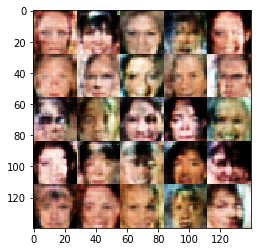

Epoch 0/1... Discriminator Loss: 5.4780... Generator Loss: 5.7558
Epoch 0/1... Discriminator Loss: 1.6419... Generator Loss: 0.3769
Epoch 0/1... Discriminator Loss: 0.0727... Generator Loss: 4.4163
Epoch 0/1... Discriminator Loss: 1.6841... Generator Loss: 0.3613
Epoch 0/1... Discriminator Loss: 0.7636... Generator Loss: 5.0996
Epoch 0/1... Discriminator Loss: 0.1049... Generator Loss: 4.3816
Epoch 0/1... Discriminator Loss: 1.8932... Generator Loss: 4.3854
Epoch 0/1... Discriminator Loss: 0.9851... Generator Loss: 0.9587
Epoch 0/1... Discriminator Loss: 0.5989... Generator Loss: 1.4777
Epoch 0/1... Discriminator Loss: 0.6151... Generator Loss: 3.0511


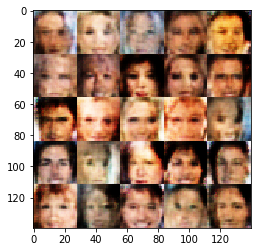

Epoch 0/1... Discriminator Loss: 0.6720... Generator Loss: 0.9817
Epoch 0/1... Discriminator Loss: 0.2959... Generator Loss: 5.5205
Epoch 0/1... Discriminator Loss: 0.0374... Generator Loss: 5.2669
Epoch 0/1... Discriminator Loss: 0.7166... Generator Loss: 1.4244
Epoch 0/1... Discriminator Loss: 0.1303... Generator Loss: 3.9594
Epoch 0/1... Discriminator Loss: 0.1215... Generator Loss: 2.9038
Epoch 0/1... Discriminator Loss: 0.1102... Generator Loss: 4.2244
Epoch 0/1... Discriminator Loss: 0.1455... Generator Loss: 3.3172
Epoch 0/1... Discriminator Loss: 0.1203... Generator Loss: 3.3460
Epoch 0/1... Discriminator Loss: 0.6293... Generator Loss: 4.5273


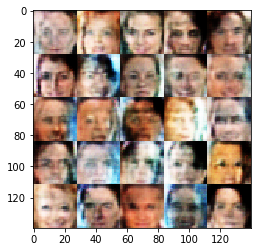

Epoch 0/1... Discriminator Loss: 0.4751... Generator Loss: 4.9793
Epoch 0/1... Discriminator Loss: 0.0312... Generator Loss: 6.0094
Epoch 0/1... Discriminator Loss: 0.0101... Generator Loss: 7.6385
Epoch 0/1... Discriminator Loss: 0.6121... Generator Loss: 1.0651
Epoch 0/1... Discriminator Loss: 0.0576... Generator Loss: 3.7715
Epoch 0/1... Discriminator Loss: 0.8452... Generator Loss: 1.0422
Epoch 0/1... Discriminator Loss: 0.1567... Generator Loss: 3.5554
Epoch 0/1... Discriminator Loss: 0.2292... Generator Loss: 2.2582
Epoch 0/1... Discriminator Loss: 2.4359... Generator Loss: 5.1797
Epoch 0/1... Discriminator Loss: 0.0873... Generator Loss: 3.2967


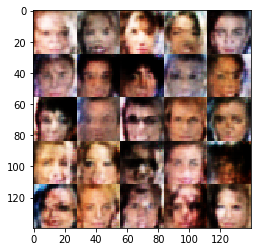

Epoch 0/1... Discriminator Loss: 1.5351... Generator Loss: 0.4022
Epoch 0/1... Discriminator Loss: 1.5646... Generator Loss: 0.5399
Epoch 0/1... Discriminator Loss: 0.2938... Generator Loss: 3.3856
Epoch 0/1... Discriminator Loss: 0.8170... Generator Loss: 1.1331
Epoch 0/1... Discriminator Loss: 0.6663... Generator Loss: 1.1837
Epoch 0/1... Discriminator Loss: 1.1976... Generator Loss: 0.6124
Epoch 0/1... Discriminator Loss: 0.3774... Generator Loss: 1.7798
Epoch 0/1... Discriminator Loss: 0.3430... Generator Loss: 3.3746
Epoch 0/1... Discriminator Loss: 0.3308... Generator Loss: 4.0212
Epoch 0/1... Discriminator Loss: 0.3537... Generator Loss: 6.2056


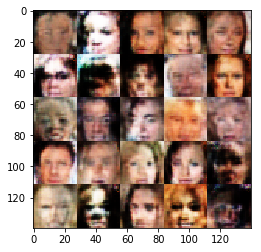

Epoch 0/1... Discriminator Loss: 0.1426... Generator Loss: 3.0562
Epoch 0/1... Discriminator Loss: 0.0567... Generator Loss: 4.1106
Epoch 0/1... Discriminator Loss: 0.0850... Generator Loss: 5.4393
Epoch 0/1... Discriminator Loss: 0.0367... Generator Loss: 7.3324
Epoch 0/1... Discriminator Loss: 0.0693... Generator Loss: 7.8699
Epoch 0/1... Discriminator Loss: 0.0526... Generator Loss: 4.0750
Epoch 0/1... Discriminator Loss: 0.3072... Generator Loss: 2.4812
Epoch 0/1... Discriminator Loss: 0.0472... Generator Loss: 4.4766
Epoch 0/1... Discriminator Loss: 0.9973... Generator Loss: 1.7287
Epoch 0/1... Discriminator Loss: 0.7224... Generator Loss: 1.2216


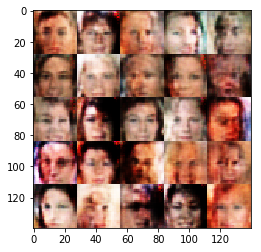

Epoch 0/1... Discriminator Loss: 0.6211... Generator Loss: 1.2878
Epoch 0/1... Discriminator Loss: 1.2240... Generator Loss: 2.9895
Epoch 0/1... Discriminator Loss: 0.5436... Generator Loss: 1.3671
Epoch 0/1... Discriminator Loss: 0.1737... Generator Loss: 2.7710
Epoch 0/1... Discriminator Loss: 1.0564... Generator Loss: 0.6147
Epoch 0/1... Discriminator Loss: 1.6081... Generator Loss: 0.3978
Epoch 0/1... Discriminator Loss: 0.0976... Generator Loss: 5.1907
Epoch 0/1... Discriminator Loss: 0.2027... Generator Loss: 3.3772
Epoch 0/1... Discriminator Loss: 1.4091... Generator Loss: 1.9343
Epoch 0/1... Discriminator Loss: 0.0207... Generator Loss: 5.6143


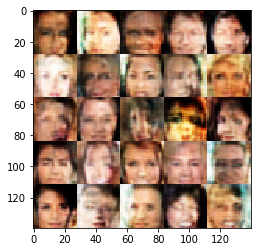

Epoch 0/1... Discriminator Loss: 0.0424... Generator Loss: 5.0538
Epoch 0/1... Discriminator Loss: 0.1669... Generator Loss: 7.3050
Epoch 0/1... Discriminator Loss: 0.0531... Generator Loss: 5.3720
Epoch 0/1... Discriminator Loss: 0.0419... Generator Loss: 4.8137
Epoch 0/1... Discriminator Loss: 2.4215... Generator Loss: 0.2863
Epoch 0/1... Discriminator Loss: 0.2773... Generator Loss: 2.1571
Epoch 0/1... Discriminator Loss: 1.7719... Generator Loss: 0.3268
Epoch 0/1... Discriminator Loss: 0.1206... Generator Loss: 6.4402
Epoch 0/1... Discriminator Loss: 0.0407... Generator Loss: 5.0412
Epoch 0/1... Discriminator Loss: 0.1915... Generator Loss: 2.2673


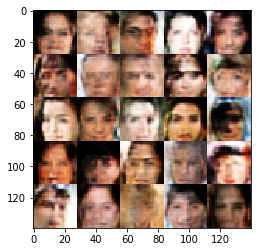

Epoch 0/1... Discriminator Loss: 0.2237... Generator Loss: 2.3223
Epoch 0/1... Discriminator Loss: 0.0526... Generator Loss: 5.5643
Epoch 0/1... Discriminator Loss: 0.0902... Generator Loss: 6.8621
Epoch 0/1... Discriminator Loss: 0.0198... Generator Loss: 6.2456
Epoch 0/1... Discriminator Loss: 0.3888... Generator Loss: 1.8319
Epoch 0/1... Discriminator Loss: 0.0897... Generator Loss: 3.7578
Epoch 0/1... Discriminator Loss: 0.4088... Generator Loss: 1.6561
Epoch 0/1... Discriminator Loss: 0.0873... Generator Loss: 4.0478
Epoch 0/1... Discriminator Loss: 0.0380... Generator Loss: 4.1844
Epoch 0/1... Discriminator Loss: 0.1802... Generator Loss: 2.8412


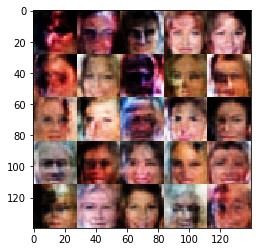

Epoch 0/1... Discriminator Loss: 0.0191... Generator Loss: 4.9464
Epoch 0/1... Discriminator Loss: 0.2449... Generator Loss: 5.2592
Epoch 0/1... Discriminator Loss: 0.0863... Generator Loss: 4.5309
Epoch 0/1... Discriminator Loss: 0.3372... Generator Loss: 1.9986
Epoch 0/1... Discriminator Loss: 0.0179... Generator Loss: 8.4778
Epoch 0/1... Discriminator Loss: 0.0987... Generator Loss: 8.7905
Epoch 0/1... Discriminator Loss: 0.0452... Generator Loss: 4.3154
Epoch 0/1... Discriminator Loss: 0.0619... Generator Loss: 3.2297
Epoch 0/1... Discriminator Loss: 1.3093... Generator Loss: 2.0080
Epoch 0/1... Discriminator Loss: 2.3856... Generator Loss: 6.1905


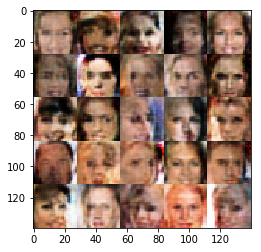

Epoch 0/1... Discriminator Loss: 0.8605... Generator Loss: 0.9993
Epoch 0/1... Discriminator Loss: 0.5359... Generator Loss: 2.7353
Epoch 0/1... Discriminator Loss: 0.5822... Generator Loss: 1.4253
Epoch 0/1... Discriminator Loss: 0.4775... Generator Loss: 1.7242
Epoch 0/1... Discriminator Loss: 0.7468... Generator Loss: 3.1269
Epoch 0/1... Discriminator Loss: 0.9668... Generator Loss: 0.6885
Epoch 0/1... Discriminator Loss: 1.2637... Generator Loss: 0.7173
Epoch 0/1... Discriminator Loss: 1.0694... Generator Loss: 0.7451
Epoch 0/1... Discriminator Loss: 0.6473... Generator Loss: 2.1230
Epoch 0/1... Discriminator Loss: 0.5042... Generator Loss: 1.9522


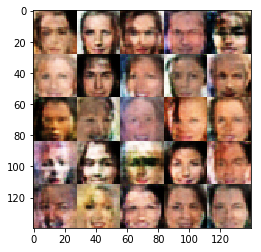

Epoch 0/1... Discriminator Loss: 1.5637... Generator Loss: 0.4444
Epoch 0/1... Discriminator Loss: 0.7288... Generator Loss: 4.0121
Epoch 0/1... Discriminator Loss: 0.3775... Generator Loss: 2.0056
Epoch 0/1... Discriminator Loss: 1.3562... Generator Loss: 5.3730
Epoch 0/1... Discriminator Loss: 0.2354... Generator Loss: 2.2955
Epoch 0/1... Discriminator Loss: 0.3487... Generator Loss: 2.6310
Epoch 0/1... Discriminator Loss: 0.2676... Generator Loss: 2.0063
Epoch 0/1... Discriminator Loss: 0.1621... Generator Loss: 2.4925
Epoch 0/1... Discriminator Loss: 0.1777... Generator Loss: 4.4718
Epoch 0/1... Discriminator Loss: 0.1477... Generator Loss: 3.6054


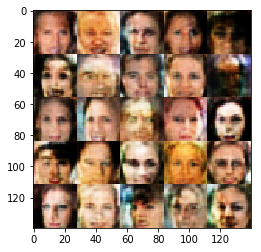

Epoch 0/1... Discriminator Loss: 0.4184... Generator Loss: 2.1106
Epoch 0/1... Discriminator Loss: 0.0611... Generator Loss: 5.4861
Epoch 0/1... Discriminator Loss: 1.7352... Generator Loss: 0.3800
Epoch 0/1... Discriminator Loss: 0.3349... Generator Loss: 1.8688
Epoch 0/1... Discriminator Loss: 0.1912... Generator Loss: 2.5647
Epoch 0/1... Discriminator Loss: 2.1244... Generator Loss: 0.2842
Epoch 0/1... Discriminator Loss: 0.4748... Generator Loss: 1.5254
Epoch 0/1... Discriminator Loss: 0.0864... Generator Loss: 5.3943
Epoch 0/1... Discriminator Loss: 0.1014... Generator Loss: 3.0168
Epoch 0/1... Discriminator Loss: 0.0358... Generator Loss: 4.4230


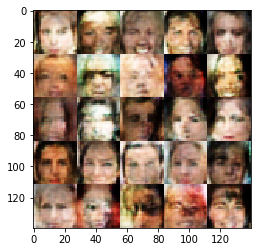

Epoch 0/1... Discriminator Loss: 0.6303... Generator Loss: 2.7440
Epoch 0/1... Discriminator Loss: 0.1874... Generator Loss: 2.9351
Epoch 0/1... Discriminator Loss: 0.3165... Generator Loss: 5.2278
Epoch 0/1... Discriminator Loss: 1.3516... Generator Loss: 0.4272
Epoch 0/1... Discriminator Loss: 0.0516... Generator Loss: 4.5719
Epoch 0/1... Discriminator Loss: 0.4994... Generator Loss: 1.2987
Epoch 0/1... Discriminator Loss: 0.0648... Generator Loss: 7.3382


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.